# Calculating OHC shoreward of the 2500m isobath, on the shelf (0-1000m depth) and on the slope (1000-2500m depth)

OHC calculated using 

\begin{equation} OHC = \int \int \rho_0 C_p \Theta \, dA dz \end{equation} 

In [27]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

import matplotlib.dates as mdates
import datetime
import pandas as pd

In [28]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36461/status,
Dashboard: /proxy/36461/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.24:35215,Workers: 0
Dashboard: /proxy/36461/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [29]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')


In [30]:
exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

In [31]:
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'

In [32]:
# Load database
session = cc.database.create_session()

In [33]:
import cf_xarray as cfxr


In [8]:
%%time
#base = '/g/data/e14/mv7494/access-om2/archive/'
#run = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/', '1deg_jra55_iaf_branch2000_PI_Offset/']
rho_0 = 1035 # kg m-3
C_p = 3992.1 # J kg-1 K-1

# temp_ctrl = linear trend in the control simulation
#temp_ctrl = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice(start_time_mw,end_time_mw)) 

temp_ctrl = cc.querying.getvar(expt=exp_ctrl, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time_mw, end_time=end_time_mw).cf.sel(latitude = lat_lim, vertical=slice(0.,3000))


CPU times: user 15 s, sys: 2.92 s, total: 17.9 s
Wall time: 3min 3s


In [47]:
temp_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time_mw, end_time=end_time_mw).cf.sel(latitude = lat_lim, vertical=slice(0.,3000))
temp_wthp = cc.querying.getvar(expt=exp_wthp, variable='temp', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time_mw, end_time=end_time_mw).cf.sel(latitude = lat_lim, vertical=slice(0.,3000))


In [10]:

'''
temp = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).temp.sel(time = slice('1972-01','2017-12')) 
'''

path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

#dzt = grid.dzt.cf.sel(time = slice(start_time_mw,end_time_mw)) 
dzt = cc.querying.getvar(expt=exp_ctrl, variable='dzt', 
                              session=session, frequency='1 monthly',
                              attrs={'cell_methods': 'time: mean'},
                              start_time=start_time_mw, end_time=end_time_mw)
area_t = grid.area_t

#temp_ctrl['time'] = temp.time # copy over time dimension so I can subtract the drift


In [11]:
temp_ctrl

<xarray.DataArray 'temp' (time: 600, st_ocean: 60, yt_ocean: 440, xt_ocean: 3600)> Size: 228GB
dask.array<getitem, shape=(600, 60, 440, 3600), dtype=float32, chunksize=(1, 7, 250, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

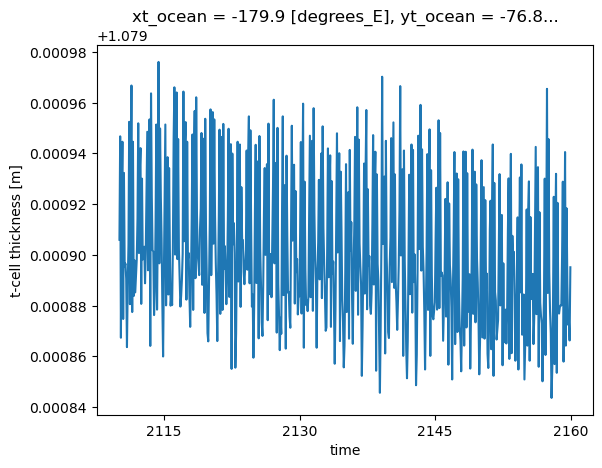

In [12]:
dzt.cf.isel(longitude = 1000,latitude = 100, vertical = 0).plot()

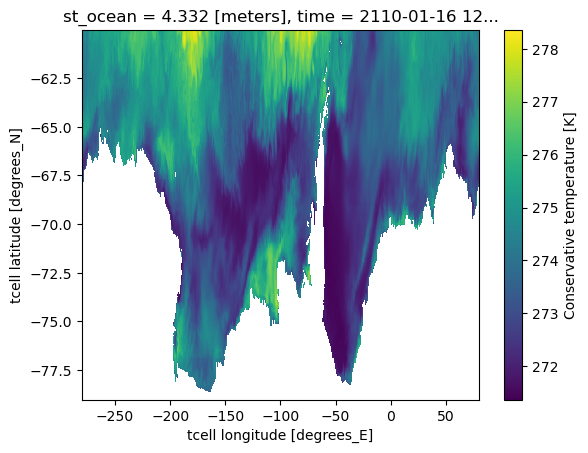

In [13]:
temp_ctrl.cf.isel(time = 0, vertical = 3).plot()

In [ ]:
%%time
# calculate OHC
OHC_ctrl = (rho_0*C_p*temp_ctrl*area_t*dzt).cf.sum(['longitude','latitude','vertical']).load()
#OHC = (rho_0*C_p*temp*area_t*dzt).cf.sel(vertical=slice(0.,3000)).sum(['longitude','latitude','depth'])


In [22]:
%%time

chunksize = 10
tt = 0
ans = (rho_0*C_p*temp_ctrl.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))*area_t*dzt.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))).cf.sum(['longitude','latitude','vertical']).load()

ans

CPU times: user 1min 47s, sys: 2.67 s, total: 1min 50s
Wall time: 1min 50s


<xarray.DataArray (time: 600)> Size: 2kB
array([9.8356823e+22, 9.8360210e+22, 9.8363137e+22, 9.8353356e+22,
       9.8343295e+22, 9.8344222e+22, 9.8341763e+22, 9.8340268e+22,
       9.8332810e+22, 9.8329288e+22, 9.8340106e+22, 9.8353058e+22,
       9.8367803e+22, 9.8382071e+22, 9.8389970e+22, 9.8385746e+22,
       9.8359661e+22, 9.8348528e+22, 9.8337638e+22, 9.8335440e+22,
       9.8341061e+22, 9.8342205e+22, 9.8341682e+22, 9.8366740e+22,
       9.8374901e+22, 9.8382980e+22, 9.8387133e+22, 9.8378468e+22,
       9.8365236e+22, 9.8368938e+22, 9.8359282e+22, 9.8350690e+22,
       9.8341908e+22, 9.8339944e+22, 9.8346402e+22, 9.8351509e+22,
       9.8381602e+22, 9.8378666e+22, 9.8377063e+22, 9.8375243e+22,
       9.8371154e+22, 9.8367263e+22, 9.8364471e+22, 9.8359688e+22,
       9.8356031e+22, 9.8351924e+22, 9.8338773e+22, 9.8337224e+22,
       9.8373928e+22, 9.8381197e+22, 9.8380170e+22, 9.8380413e+22,
       9.8373811e+22, 9.8367803e+22, 9.8360642e+22, 9.8355211e+22,
       9.8339755e+22, 9.8343862e+22, 9.8344565e+22, 9.8334891e+22,
       9.8363561e+22, 9.8370595e+22, 9.8367173e+22, 9.8361129e+22,
       9.8358688e+22, 9.8353869e+22, 9.8343772e+22, 9.8344637e+22,
       9.8355634e+22, 9.8353788e+22, 9.8358994e+22, 9.8361606e+22,
       9.8374784e+22, 9.8373604e+22, 9.8379477e+22, 9.8378080e+22,
       9.8369695e+22, 9.8365281e+22, 9.8362075e+22, 9.8366470e+22,
...
       9.8320065e+22, 9.8319831e+22, 9.8318210e+22, 9.8323560e+22,
       9.8326802e+22, 9.8348258e+22, 9.8358418e+22, 9.8358003e+22,
       9.8348960e+22, 9.8354905e+22, 9.8342961e+22, 9.8335729e+22,
       9.8327982e+22, 9.8324037e+22, 9.8330117e+22, 9.8329901e+22,
       9.8330576e+22, 9.8354211e+22, 9.8362669e+22, 9.8357247e+22,
       9.8340800e+22, 9.8323956e+22, 9.8325118e+22, 9.8324199e+22,
       9.8324560e+22, 9.8319002e+22, 9.8321632e+22, 9.8332036e+22,
       9.8345402e+22, 9.8356661e+22, 9.8360102e+22, 9.8363732e+22,
       9.8347924e+22, 9.8347249e+22, 9.8344673e+22, 9.8339602e+22,
       9.8328235e+22, 9.8328135e+22, 9.8338602e+22, 9.8350077e+22,
       9.8346645e+22, 9.8353419e+22, 9.8358553e+22, 9.8353500e+22,
       9.8346744e+22, 9.8331603e+22, 9.8324407e+22, 9.8320840e+22,
       9.8319633e+22, 9.8320434e+22, 9.8336746e+22, 9.8341844e+22,
       9.8353644e+22, 9.8371235e+22, 9.8380062e+22, 9.8372946e+22,
       9.8375315e+22, 9.8359661e+22, 9.8350419e+22, 9.8338368e+22,
       9.8323830e+22, 9.8320975e+22, 9.8327649e+22, 9.8346384e+22,
       9.8345429e+22, 9.8355319e+22, 9.8364651e+22, 9.8357355e+22,
       9.8350095e+22, 9.8348501e+22, 9.8338332e+22, 9.8339413e+22,
       9.8346060e+22, 9.8348330e+22, 9.8344222e+22, 9.8341439e+22],
      dtype=float32)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00

In [23]:
%%time

chunksize = 1000
tt = 0
ans = (rho_0*C_p*temp_ctrl.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))*area_t*dzt.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))).cf.sum(['longitude','latitude','vertical']).load()

ans

CPU times: user 5min 13s, sys: 8.17 s, total: 5min 22s
Wall time: 5min 20s


<xarray.DataArray (time: 600)> Size: 2kB
array([1.1610691e+25, 1.1611588e+25, 1.1611440e+25, 1.1611028e+25,
       1.1610410e+25, 1.1609504e+25, 1.1608972e+25, 1.1608568e+25,
       1.1608063e+25, 1.1607892e+25, 1.1608249e+25, 1.1609338e+25,
       1.1610800e+25, 1.1611701e+25, 1.1611624e+25, 1.1611213e+25,
       1.1610481e+25, 1.1609500e+25, 1.1609094e+25, 1.1608707e+25,
       1.1608277e+25, 1.1608092e+25, 1.1608458e+25, 1.1609574e+25,
       1.1610882e+25, 1.1611696e+25, 1.1611678e+25, 1.1611279e+25,
       1.1610570e+25, 1.1609613e+25, 1.1609110e+25, 1.1608663e+25,
       1.1608222e+25, 1.1608068e+25, 1.1608388e+25, 1.1609533e+25,
       1.1610964e+25, 1.1611723e+25, 1.1611701e+25, 1.1611262e+25,
       1.1610671e+25, 1.1609754e+25, 1.1609262e+25, 1.1608910e+25,
       1.1608455e+25, 1.1608234e+25, 1.1608565e+25, 1.1609657e+25,
       1.1611142e+25, 1.1611995e+25, 1.1611893e+25, 1.1611451e+25,
       1.1610774e+25, 1.1609686e+25, 1.1609104e+25, 1.1608782e+25,
       1.1608304e+25, 1.1608037e+25, 1.1608315e+25, 1.1609425e+25,
       1.1610951e+25, 1.1611837e+25, 1.1611773e+25, 1.1611378e+25,
       1.1610770e+25, 1.1609843e+25, 1.1609309e+25, 1.1608884e+25,
       1.1608370e+25, 1.1608097e+25, 1.1608373e+25, 1.1609400e+25,
       1.1610932e+25, 1.1611727e+25, 1.1611658e+25, 1.1611196e+25,
       1.1610535e+25, 1.1609609e+25, 1.1609174e+25, 1.1608739e+25,
...
       1.1606574e+25, 1.1606374e+25, 1.1606660e+25, 1.1607750e+25,
       1.1609204e+25, 1.1610008e+25, 1.1610003e+25, 1.1609529e+25,
       1.1608898e+25, 1.1607956e+25, 1.1607452e+25, 1.1607040e+25,
       1.1606613e+25, 1.1606399e+25, 1.1606771e+25, 1.1607845e+25,
       1.1609299e+25, 1.1610146e+25, 1.1610110e+25, 1.1609699e+25,
       1.1609018e+25, 1.1608060e+25, 1.1607539e+25, 1.1607139e+25,
       1.1606725e+25, 1.1606551e+25, 1.1606795e+25, 1.1607898e+25,
       1.1609364e+25, 1.1610267e+25, 1.1610133e+25, 1.1609688e+25,
       1.1608958e+25, 1.1608016e+25, 1.1607510e+25, 1.1607119e+25,
       1.1606665e+25, 1.1606440e+25, 1.1606766e+25, 1.1607833e+25,
       1.1609243e+25, 1.1609983e+25, 1.1609878e+25, 1.1609417e+25,
       1.1608794e+25, 1.1607920e+25, 1.1607353e+25, 1.1607030e+25,
       1.1606563e+25, 1.1606382e+25, 1.1606705e+25, 1.1607724e+25,
       1.1609318e+25, 1.1610136e+25, 1.1610024e+25, 1.1609627e+25,
       1.1608993e+25, 1.1608036e+25, 1.1607508e+25, 1.1607065e+25,
       1.1606637e+25, 1.1606469e+25, 1.1606867e+25, 1.1607950e+25,
       1.1609372e+25, 1.1610256e+25, 1.1610196e+25, 1.1609635e+25,
       1.1608911e+25, 1.1607958e+25, 1.1607489e+25, 1.1607119e+25,
       1.1606606e+25, 1.1606414e+25, 1.1606749e+25, 1.1607919e+25],
      dtype=float32)
Coordinates:
  * time     (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00

In [36]:
def calculate_OHC(temp,mask_region, chunksize):
    '''
    calculating OHC for ACCESS with 3d temp data
    .where(mask_region == True).where(cluster_mask_access == True)
    ''' 
    OHC_arr = []
    for tt in range(0,4):#,int(len(temp.time)/chunksize)):
        OHC_elem = rho_0*C_p*temp_ctrl.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))*area_t*dzt.cf.isel(longitude = slice(tt*chunksize, (tt+1)*chunksize))
        OHC_ctrl = OHC_elem.cf.sum(['longitude','latitude','vertical']).load()
        OHC_arr.append(OHC_ctrl)
        print(tt ,' is done')
    return OHC_arr

In [37]:
%%time
OHC_ctrl = calculate_OHC(temp_ctrl,cluster_mask_access , 1000)

0  is done
1  is done
2  is done
3  is done
CPU times: user 18min 52s, sys: 54.6 s, total: 19min 47s
Wall time: 19min 13s


In [48]:
OHC_ctrl_arr = xr.merge(OHC_ctrl.to_dataset(name='OHC'))

AttributeError: 'list' object has no attribute 'to_dataset'

In [ ]:
## change masked region in question
region = 'Shelf region'
## Change the above line

if region == 'Slope region':
    mask_region = mask_slope
elif region == 'Shelf region':
    mask_region = mask_shelf


In [43]:
hu = cc.querying.getvar(exp_wthmp, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).sel(yu_ocean=lat_lim).load() #.drop(['geolat_c', 'geolon_c'])

In [44]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [45]:
%%time
OHC_ctrl_slope = calculate_OHC(temp_ctrl,mask_slope , 1000)

0  is done
1  is done
2  is done
3  is done
CPU times: user 18min 51s, sys: 54.4 s, total: 19min 45s
Wall time: 19min 11s


In [ ]:
OHC_ctrl_slope_arr = xr.merge(OHC_ctrl_slope.to_dataset(name='OHC'))

In [46]:
%%time
OHC_ctrl_shelf = calculate_OHC(temp_ctrl,mask_shelf , 1000)

0  is done
1  is done
2  is done
3  is done
CPU times: user 18min 41s, sys: 53.6 s, total: 19min 35s
Wall time: 19min


In [ ]:
OHC_ctrl_shelf_arr = xr.merge(OHC_ctrl_shelf.to_dataset(name='OHC'))

In [ ]:
%%time
OHC_wthmp = calculate_OHC(temp_ctrl,cluster_mask_access , 1000)

In [ ]:
%%time
OHC_wthmp_slope = calculate_OHC(temp_wthmp,mask_slope , 1000)

In [ ]:
%%time
OHC_wthmp_shelf = calculate_OHC(temp_wthmp,mask_shelf , 1000)